# 12. Problems

## Preamble

In [2]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline as interpolate
from scipy.optimize import root, fsolve, curve_fit
from scipy.misc import derivative
import scipy.linalg as lg
# PDF = Probability Distribution Function (smooth Histogram)
from scipy.stats import gaussian_kde as PDF  
# find maximas (peaks) in a list
from scipy.signal import find_peaks

import sympy as sp
import fractions as fra
import itertools as itr

# install the tabulate module using: "conda install tabulate"
from tabulate import tabulate

from ipywidgets import interact

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.ticker as ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
%run -i "rcParameters.py"
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["font.family"]='Times New Roman'
plt.rcParams["mathtext.fontset"]='stix';

In [4]:
# set fontsize in markdown cells
from IPython.core.display import display, HTML, Latex
display(HTML("<style>.rendered_html { font-size: 16px; }</style>"))

In [5]:
def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = np.int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex

    def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)

    def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))


In [6]:
# turn off certain annoying warnings 
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in sqrt")

## Utility functions

In [12]:
# chop(expr) = 0 if |expr| < delta
def chop(expr, delta=10**-10):
    return np.ma.masked_inside(expr, -delta, delta).filled(0)


In [13]:
# Bifurcation diagram: x vs r
def BF_diag(f,x1,x2,r1,r2,nx=80,nr=80,col='k',title='',x_lab='$r$',y_lab='$x^\star$'):
    fx = lambda x,r: derivative(f,x,dx=1e-6,args=(r,))
    x=np.linspace(x1,x2,nx)
    r=np.linspace(r1,r2,nr)
    R,X = np.meshgrid(r,x)
    Z = f(X,R)
    Zx= fx(X,R)
    Zu= np.ma.masked_where(Zx<0,Z)
    Zs= np.ma.masked_where(Zx>0,Z)

    fig, ax=plt.subplots(figsize=(6,4))
    ax.contour(R,X,Zs,levels=[0],colors=col,linewidths=3)
    ax.contour(R,X,Zu,levels=[0],colors=col,linewidths=3,linestyles='dashed')
    ax.grid()
    ax.set_xlabel(x_lab)
    ax.set_ylabel(y_lab)
    ax.set_title(title,color='b')
    plt.show()    

In [14]:
# Phase portrait: streamplot X,Y,Vx=dx/dt,Vy=dy/dt
def PP_2d(x1,x2,y1,y2,f1,f2,ax,nx=100,ny=100,dens=[1,1],lw=1,col='k'):
    ax = ax or plt.gca()
    x = np.linspace(x1,x2,nx)
    y = np.linspace(y1,y2,ny)
    X,Y = np.meshgrid(x,y)
    U = f1(X,Y); V = f2(X,Y)
    ax.streamplot(X,Y,U,V,density=dens,
                 linewidth=lw,color=col,arrowstyle='->')
    return ax

# Phase portrait: streamlines through selected points
def PP_2d_sp(x1,x2,y1,y2,f1,f2,seed_points,ax,nx=100,ny=100,dens=[1,1],lw=1,col='k',ar_s='->'):
    ax = ax or plt.gca()
    x = np.linspace(x1,x2,nx)
    y = np.linspace(y1,y2,ny)
    X,Y = np.meshgrid(x,y)
    U = f1(X,Y); V = f2(X,Y)    
    ax.streamplot(X,Y,U,V,density=dens,start_points=seed_points.T,
                 linewidth=lw,color=col,arrowstyle=ar_s)
    return ax    

# Phase portrait: streamlines through selected points + nullclines
def PP_2d_sp_nc(x1,x2,y1,y2,f1,f2,seed_points,ax,nx=100,ny=100,dens=[1,1],lw=1,col='k',ar_s='->'):
    ax = ax or plt.gca()
    x = np.linspace(x1,x2,nx)
    y = np.linspace(y1,y2,ny)
    X,Y = np.meshgrid(x,y)
    U = f1(X,Y); V = f2(X,Y)    
    ax.streamplot(X,Y,U,V,density=dens,start_points=seed_points.T,
                 linewidth=lw,color=col,arrowstyle=ar_s)
    ax.contour(X,Y,U,[0],colors='m')
    ax.contour(X,Y,V,[0],colors='b')
    return ax    

# Phase portrait: nullclines
def PP_nc(x1,x2,y1,y2,f1,f2,ax,nx=100,ny=100,lw=1,c1='m',c2='b'):
    ax = ax or plt.gca()
    x = np.linspace(x1,x2,nx)
    y = np.linspace(y1,y2,ny)
    X,Y = np.meshgrid(x,y)
    U = f1(X,Y); V = f2(X,Y)    
    ax.contour(X,Y,U,[0],colors='m')
    ax.contour(X,Y,V,[0],colors='b')
    return ax    

# Display fixed points
def PP_FPs(FPs,tau,delta,ax):
    ax = ax or plt.gca()
    for j in np.arange(len(FPs)):
        FP_ = np.array(FPs[j],dtype=float) 
        if tau[j]<0 and delta[j]>0:
            print('stable FP: ',FP_)
            ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='r',mec='r',lw=2)
        else:
            print('unstable FP: ',FP_)
            ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='w',mec='r',lw=2)
    return ax

In [15]:
def get_FP_data(f1,f2,tab=True):
    '''
    input: f1(x,y) and f2(x,y) for 2D dynamical system
    output: FPs and attributes: tau, delta, tau^2-4.delta, 
                                eigen-values/-vectors of Jacobian matrix
    '''
    FPs = sp.solve((f1(x,y),f2(x,y)),x,y) 
    FPsd= [{x:a[0],y:a[1]} for a in FPs]
    print('Fixed points: ',FPsd)

    A = lambda x,y: sp.Matrix([f1(x,y),f2(x,y)]).jacobian([x,y])
    display(Latex(r'$A ={}$'.format(sp.latex(A(x,y)))))

    A_FPs = [A(x,y).subs(a) for a in FPsd]
    display(Latex(r'For each FP evaluate $A$, $\tau=Tr(A)$, $\Delta=det(A)$, $\tau^2-4\Delta$, $\lambda_{{1,2}}$, and $v_{{1,2}}$'))
    [display(a) for a in A_FPs];

    tau   = [a.trace() for a in A_FPs]
    display(Latex(r'$\tau = {}$'.format(sp.latex(tau))))
    delta = [a.det()   for a in A_FPs]
    display(Latex(r'$\Delta = {}$'.format(sp.latex(delta))))
    disc  = [t**2 - 4*d for t,d in zip(tau,delta)]
    display(Latex(r'$\tau^2-4\Delta = {}$'.format(sp.latex(disc))))

    # calculate eigenvalues and eigenfunctions of the Jacobian matrices for each FP
    eig_sys = [a.eigenvects() for a in A_FPs]
    mu = [[a[0][0],a[1][0]] for a in eig_sys]
    display(Latex(r'$\lambda_{{1,2}} = {}$'.format(sp.latex(mu))))
    V  = [[list(a[0][2][0]),list(a[1][2][0])] for a in eig_sys]
    display(Latex(r'$V_{{1,2}} = {}$'.format(sp.latex(V))))

    # tabulate data for FPs
    if tab :
        table=[[FPsd[i],tau[i],delta[i],disc[i],mu[i],V[i]] for i in np.arange(len(FPs))]
        print(tabulate(table,headers=('Fixed point','tau','delta','disc','lambda','eigenvectors'),
                   tablefmt='fancy_grid'))
    return FPs, tau, delta, disc, mu, V

In [16]:
# functions to calculate trajectory {x(t),y(t)} numerically for given {x0,y0} 
# input: functions f1,f2; duration T and timestep dt of trajectory; initial condition xy0=[x0,y0]
# output: [t,sol] = [t,[x(t),y(t)]]

def txy_traj(f1,f2,T,dt,xy0):
    t = np.arange(0,T+dt,dt)
    def RHS(xy,t):
        x,y=xy
        return[f1(x,y),f2(x,y)]
    sol = odeint(RHS,xy0,t)
    return [t,sol]

In [14]:
# functions to solve LE  
# input: parameters sigma,a,b; duration T and timestep dt; initial condition xyz0=[x0,y0,z0]
# output: [t,sol] = [t,[x(t),y(t),z(t)]]

def txyz_LE(sigma,r,b,T,dt,xyz0):
    t = np.arange(0,T+dt,dt)
    def RHS(xyz,t):
        x,y,z=xyz
        return[sigma*(y-x),r*x-y-x*z,x*y-b*z]
    sol = odeint(RHS,xyz0,t)
    return [t,sol]

In [19]:
# functions to solve the Rossler system (RS) 
# input: parameters sigma,a,b; duration T and timestep dt; initial condition xyz0=[x0,y0,z0]
# output: [t,sol] = [t,[x(t),y(t),z(t)]]

def txyz_RS(a,b,c,T,dt,xyz0):
    t = np.arange(0,T+dt,dt)
    def RHS(xyz,t):
        x,y,z=xyz
        return[-y-z,x+a*y,b+z*(x-c)]
    sol = odeint(RHS,xyz0,t)
    return [t,sol]

In [20]:
# NestList(f,x0,n0) and Nest(f,x,n)
def NestList(f,x0,n0):
    '''
    generate nested list by applying f n=0,...,n0 times on x0
    input:  f(x,_), x0, n0=integer
    output: [x0,f(x0),f(f(x0)),...,f(...(f(x0)))]
    '''
    return [a for a in itr.accumulate(itr.repeat(x0,n0),f)]

def Nest(f,x,n):
    '''Applies function f n-times to x'''
    if n==0:
        return x
    return Nest(f,f(x),n-1)

In [21]:
# define Logistic Map (LM) and LM series
f_LM = lambda x,r: r*x*(1-x)
def logistic_series(x0,r,n):
    f = lambda x,_: f_LM(x,r)
    return NestList(f,x0,n)

In [22]:
# plot cobweb x_(n+1)=f(x_n)
def cobweb_f(f,x0,n0,ax,ls='-',col='r',lw=1):
    ax = ax or plt.gca
    f_ = lambda x,_: f(x)
    dat = NestList(f_,x0,n0)
    x = list(itr.chain(*zip(dat,dat)))
    ax.plot(x[:-1],x[1:],c=col,ls=ls,lw=lw)
    return ax

# plot cobweb {x_0,...,x_n}
def cobweb_x(xdat,ax,ls='-',col='r',lw=1,nS=1):
    ax = ax or plt.gca
    x = list(itr.chain(*zip(xdat,xdat)))
    ax.plot(x[nS:-1],x[nS+1:],c=col,ls=ls,lw=lw)
    return ax

In [23]:
# define HM and T_i, i=1,2,3
def fT1(xy,a):
    x,y = xy
    return [x,1+y-a*x**2]
def fT2(xy,b):
    x,y=xy
    return [b*x,y]
def fT3(xy):
    x,y=xy
    return [y,x]
def HM(xy,a,b):
    x,y=xy
    return [y+1-a*x**2,b*x]

# define HM series
def HM_series(xy0,a,b,n):
    f = lambda xy,_: HM(xy,a,b)
    return NestList(f,xy0,n)

## P. 12.5.2

(Coexisting chaos and limit cycle) Consider the double-well oscillator $V(x)=x^4/4-x^2/2$ with parameters $\delta =0.15$, $F_0 = 0.3$, and $\omega = 1$. Show numerically that the system has at least two coexisting attractors: a large limit cycle and a smaller strange attractor. Plot both in a Poincare section.

In [24]:
# functions to solve the Forced Double-Well Oscillator (F2WO) 
# input: parameters delta, F0, omega; duration T and timestep dt; initial condition xyz0=[x0,y0,0]
# output: sol = [x(t),y(t),z(t)=t]

def xyz_F2WO(delta,F0,omega,T,dt,xyz0):
    t = np.arange(0,T+dt,dt)
    def RHS(xyz,t):
        x,y,z=xyz
        return[y,x-x**3-delta*y+F0*np.cos(omega*z),1]
    sol = odeint(RHS,xyz0,t)
    return sol

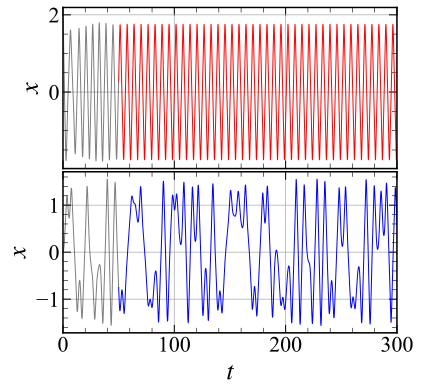

In [25]:
delta=0.15; omega=1.; F0=0.3

# solve F2WO
T=300; dt=0.01
t0=50; t0_=int(t0/dt)

# limit cycle
xyz0=[2,0,0]
xyz1 = xyz_F2WO(delta,F0,omega,T,dt,xyz0)

# strange attractor
xyz0=[0,0,0]
xyz2 = xyz_F2WO(delta,F0,omega,T,dt,xyz0)


# Plot x-t [0<t<T]
fig_xt, ax = plt.subplots(2,1,figsize=(6,6),sharex=True,
                         gridspec_kw=dict(wspace=0.02,hspace=0.02))
ax[0].plot(xyz1[:t0_,2], xyz1[:t0_,0],'k-',lw=1,alpha=0.5)
ax[0].plot(xyz1[t0_:,2], xyz1[t0_:,0],'r-',lw=1,alpha=1)
ax[1].plot(xyz2[:t0_,2], xyz2[:t0_,0],'k-',lw=1,alpha=0.5)
ax[1].plot(xyz2[t0_:,2], xyz2[t0_:,0],'b-',lw=1,alpha=1)


ax[1].set_xlabel('$t$')
ax[1].set_xlim(0,T)
[a.set_ylabel('$x$') for a in ax]
# ax.set_yticks(np.arange(0,1.3,0.2))
[a.grid() for a in ax]
# fig_xt.savefig('FIGS/P12-5-2_F2WO-xt_1.pdf')
plt.show()

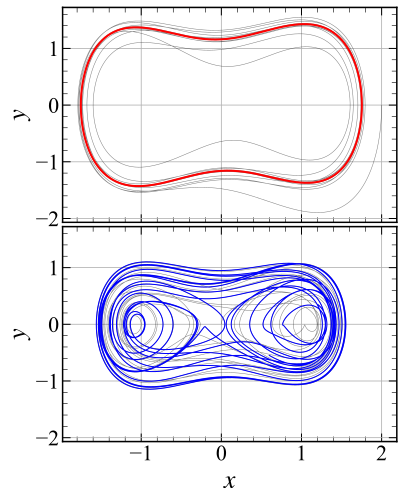

In [26]:
# Plot x-y 
t01=200; t01_=int(t01/dt)
t02=150; t02_=int(t02/dt)

fig_xy, ax = plt.subplots(2,1,figsize=(6,8),sharex=True,sharey=True,
                         gridspec_kw=dict(wspace=0.02,hspace=0.02))
ax[0].plot(xyz1[:,0], xyz1[:,1],'k-',lw=0.5,alpha=0.5)
ax[0].plot(xyz1[t01_:,0], xyz1[t01_:,1],'r-',lw=2,alpha=1)
ax[1].plot(xyz2[:,0], xyz2[:,1],'k-',lw=0.5,alpha=0.5)
ax[1].plot(xyz2[t02_:,0], xyz2[t02_:,1],'b-',lw=1,alpha=1)

ax[1].set_xlabel('$x$')
[a.set_ylabel('$y$') for a in ax]
# ax.set_xlim(-3,3)
# ax.set_ylim(-3,3)
# ax.set_xticks(np.arange(-2,2,1))
# ax.set_yticks(np.arange(-0.4,0.5,0.2))
[a.grid() for a in ax]
# fig_xy.savefig('FIGS/P12-5-3_F2WO-xy_1.pdf')
plt.show()

In [ ]:
# Poincare section {x_p,y_p}={x(2pi/omega*n),y(2pi/omega*n)}, n=0,1,...
# solve F2WO
Tp=10000; dtp=1; t02p=100; t02p_=int(t02p/dtp)
xyz0=[0,0,0]
xyz2p = xyz_F2WO(delta,F0,omega,Tp,dtp,xyz0)

xt2 = interpolate(xyz2p[:,2],xyz2p[:,0])
yt2 = interpolate(xyz2p[:,2],xyz2p[:,1])
tT = np.arange(t02p,Tp,2*np.pi/omega)

In [ ]:
Tp1=1000; dtp1=1; t01p=200; t01p_=int(t01p/dtp1)
xyz0=[2,0,0]
xyz1p = xyz_F2WO(delta,F0,omega,Tp1,dtp1,xyz0)

xt1 = interpolate(xyz1p[:,2],xyz1p[:,0])
yt1 = interpolate(xyz1p[:,2],xyz1p[:,1])
tT1 = np.arange(t01p,Tp1,2*np.pi/omega)

In [ ]:
fig_xyP, ax=plt.subplots(figsize=(6,4))
ax.plot(xt2(tT),yt2(tT),'o',ms=1,mfc='b',mec='b',mew=1)

ax.plot(xt1(tT1),yt1(tT1),'o',ms=1,mfc='r',mec='r',mew=1)

ax.set_xlabel('$x_p$')
ax.set_ylabel('$y_p$')

ax.set_xlim(-2,1.5)
ax.set_ylim(-1,2)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))

ax.grid()
# fig_xyP.savefig('FIGS/12_F2WO-xp-yp_1a.pdf')
plt.show()

## P. 12.5.4

(Chaos in the damped driven pendulum) Consider the forced pendulum $\ddot{\theta}+ b\dot{\theta}+\sin(\theta) = F \cos t$, with $b =0.22$, $F=2.7$.

#### (a) Starting from any reasonable initial condition, use numerical integration to compute $\dot{\theta}(t)$. Show that the time series has an erratic appearance, and interpret it in terms of the pendulum's motion.

Define $x=\theta$, $y=\dot\theta$ and $z=t$. The ODEs for $\{x,y,z\}$ are

\begin{eqnarray*}
\dot{x} &=& y  \\
\dot{y} &=& -\sin(x)-by+F\cos(z) \\
\dot{z} &=& 1
\end{eqnarray*}


In [ ]:
# integrate Forced Pendulum 
def xyz_FP(b,F,T,dt,xyz0):
    t = np.arange(0,T+dt,dt)
    def RHS(xyz,t):
        x,y,z=xyz
        return[y,-np.sin(x)-b*y+F*np.cos(z),1]
    sol = odeint(RHS,xyz0,t)
    return sol

In [ ]:
T=150; dt=0.1
xyz0=[0,0,0]
b0=0.22; F0=2.7
xyt = xyz_FP(b0,F0,T,dt,xyz0)

In [ ]:
# Plot x-t/y-t [0<t<T]
t0=50; t0_=int(t0/dt)
fig_xyt, ax = plt.subplots(2,1,figsize=(6,6),sharex=True,
                         gridspec_kw=dict(wspace=0.02,hspace=0.02))
ax[0].plot(xyt[:t0_,2], np.mod(xyt[:t0_,0],2*np.pi)-np.pi,'k-',lw=1,alpha=0.5)
ax[0].plot(xyt[t0_:,2], np.mod(xyt[t0_:,0],2*np.pi)-np.pi,'r-',lw=1,alpha=1)
ax[1].plot(xyt[:t0_,2], xyt[:t0_,1],'k-',lw=1,alpha=0.5)
ax[1].plot(xyt[t0_:,2], xyt[t0_:,1],'b-',lw=1,alpha=1)


ax[1].set_xlabel('$t$')
ax[1].set_xlim(0,T)
ax[0].set_ylabel(r'$\theta$') 
ax[1].set_ylabel(r'$\dot\theta$')

ax[0].yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2 ))
ax[0].yaxis.set_minor_locator(plt.MultipleLocator(np.pi / 4))
ax[0].yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))

# ax.set_yticks(np.arange(0,1.3,0.2))
fig_xyt.align_ylabels()
[a.grid() for a in ax]
# fig_xt.savefig('FIGS/P12-5-4_1.pdf')
plt.show()

#### (b) Plot the Poincare section by strobing the system whenever $t = 2\pi k$, where $k$ is an integer.

In [ ]:
# Poincare section {x(2pi*k),y(2pi*k)}, k=0,1,...
# solve F2WO
dt=2*np.pi; T=10050*dt
xyz0=[0,0,0]
b0=0.22; F0=2.7
xyt = xyz_FP(b0,F0,T,dt,xyz0)

In [ ]:
box = lambda x1,x2,y1,y2:[[x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1]]
fig_xyP, ax=plt.subplots(figsize=(6,4))
ms=0.6
ax.plot(np.mod(xyt[50:,0],4*np.pi)-np.pi,xyt[50:,1],'o',ms=ms,mfc='r',mec='r',mew=ms)

ax.set_xlabel('$x_p$')
ax.set_ylabel('$y_p$')
x_m = np.pi
ax.set_xlim(-x_m,3*x_m)
# ax.set_ylim(-0.7,1.3)
ax.grid()

ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi ))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 4))
ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
ax.set_yticks(np.arange(-1,4,1))

bb = box(1,2,1,1.5)
ax.plot(bb[0],bb[1],'k-',lw=1)

# fig_xyP.savefig('FIGS/P12-5-5_2.pdf')
plt.show()

#### (c) Zoom in on part of the strange attractor found in part (b). Enlarge a region that reveals the Cantor-like cross section of the attractor.

In [ ]:
fig_xyP, ax=plt.subplots(figsize=(6,4))
ms=1
ax.plot(np.mod(xyt[50:,0],2*np.pi)-np.pi,xyt[50:,1],'o',ms=ms,mfc='r',mec='r',mew=ms)

ax.set_xlabel('$x_p$')
ax.set_ylabel('$y_p$')

ax.set_xlim(1,2)
ax.set_ylim(1.1,1.5)

ax.grid()

# fig_xyP.savefig('FIGS/P12-5-5_3.pdf')
plt.show()

## Henon Map problems

### 12.2.4

Find all the fixed points of the Henon map and show that they exist only if $a > a_0$, where $a_0$ is to be determined.

In [ ]:
x,y = sp.symbols('x,y',real=True)
a,b = sp.symbols('a,b',real=True)
f1 = lambda x,y: y+1-a*x**2
f2 = lambda x,y: b*x

FPs = sp.solve((f1(x,y)-x,f2(x,y)-y),x,y) 
FPsd= [{x:a[0].simplify(),y:a[1]} for a in FPs]

print('Two fixed points: ')
[display(Latex('$x={}, y={}$'.format(sp.latex(a[x]),sp.latex(a[y])))) for a in FPsd];

Fixed points exist only if $a>a_0\equiv -(b-1)^2/4$

### 12.2.5

Calculate the Jacobian matrix of the Henon map and find its eigenvalues.

In [ ]:
A = lambda x,y: sp.Matrix([f1(x,y),f2(x,y)]).jacobian([x,y])

display(Latex(r'$A ={}$'.format(sp.latex(A(x,y)))))
print(48*'-')

A_FPs = [A(x,y).subs({x:a[x],y:a[y]}) for a in FPsd]
[display(a) for a in A_FPs];


Calculate eigenvalues of the Jacobian matrix as a function of the FP $(x,y)$

In [ ]:
ES = A(x,y).eigenvects()
EV1,EV2 = [ES[i][0] for i in [0,1]]
display(Latex('$\lambda_-(x)={}$'.format(sp.latex(EV1))))
display(Latex('$\lambda_+(x)={}$'.format(sp.latex(EV2))))

Calculate eigenvalues of the Jacobian matrix for each FP

In [ ]:
eig_sys = [a.eigenvects() for a in A_FPs]
l1,l2 = [[a[0][0],a[1][0]] for a in eig_sys]
display(Latex(r'$\lambda_{{1,\mp}} = {}$'.format(sp.latex(l1))))
display(Latex(r'$\lambda_{{2,\mp}} = {}$'.format(sp.latex(l2))))

### 12.2.6

A fixed point of a map is linearly stable if and only if all eigenvalues of the Jacobian satisfy $|\lambda|<1$. Determine the stability of the fixed points of the Henon map, as a function of $a$ and $b$. Show that one fixed point is always unstable, while the other is stable for $a$ slightly larger than $a_0$. Show that this fixed point loses stability in a flip bifurcation ($\lambda=-1$) at $a_1=\frac{3}{4}(1-b)^2$.

In [ ]:
# define the eigenvalues as function of (a,b) for numerical (numpy) evaluation
fl1m,fl1p = [sp.lambdify([a,b],l,'numpy') for l in l1]
fl2m,fl2p = [sp.lambdify([a,b],l,'numpy') for l in l2]

In [ ]:
# plot the stability diagram (a,b)
n_=1000
a_=np.linspace(-2,4,n_)
b_=np.linspace(-2,4,n_)

A_,B_ = np.meshgrid(a_,b_)
Z2m = fl2m(A_,B_)
Z2p = fl2p(A_,B_)

fig, ax=plt.subplots()
# delimit region with |lambda|<1
ax.contourf(A_,B_, Z2p,levels=[-1,1],colors=['gold','g','c','m'],alpha=0.5)
ax.contourf(A_,B_, Z2m,levels=[-1,1],colors=['r','b','m','c','g'],alpha=0.8)


# plot the curve: a = a0 = -(1-b)^2/4 that defines the boundary for the real FPs (x1,y1) and (x2,y2)
ax.plot(-(b_[::10]-1)**2/4,b_[::10],'b-',lw=2,alpha=0.7,label='$a=-(b-1)^2/4$')

# plot the curve: a = a1 = (3/4)(1-b)^2 that defines the boundary of the stable FPs (x2,y2)
ax.plot(3*(1-b_[b_<1])**2/4,b_[b_<1],c='c',lw=3,label='$a=3(b-1)^2/4$')

# fig legend
ax.legend(loc=5,fontsize=18)

ax.grid()
ax.set_xlim(-2.5,4)

ax.set_xlabel('$a$')
ax.set_ylabel('$b$')

# annotations
ax.text(-2,1.1,'complex FP',color='b',fontsize=22)
ax.text(-0.4,-1.3,'complex eigenvalues',fontsize=22)

ax.text(0.5,2.6,'$|\lambda_{{2+}}|<1$',fontsize=22)
ax.text(0.5,2.1,'$|\lambda_{{2-}}|>1$',fontsize=22)

ax.set_title('Linearly stable FP in the Red region: $|\lambda_{{2\pm}}|<1$', color='r')


plt.show()

In [ ]:
# b=1-z, z>0
z = sp.symbols('z',nonnegative=True)
l2[0].subs(a,3*(1-b)**2/4).subs(b,1-z).simplify()

In [ ]:
l2[1].subs(a,3*(1-b)**2/4).subs(b,1-z).simplify()

For $-1<b<1 \;\rightarrow\; b=1-z$, with $0<z<2\;\rightarrow\; \lambda_{{2-}}=-1$ and $|\lambda_{{2+}}|<1$.

### 12.2.7

Consider the Henon map with $-1 < b < 1$. Show that the map has a 2-cycle for $a> a_1=\frac{3}{4}(1-b)^2$. For which values of $a$ is the 2-cycle stable?

## P. 12.4.3

Numerically integrate the Rossler system for $a=0.4$, $b=2$, $c=4$, and obtain a long time series for $x(t)$. Then use the attractor-reconstruction method for various values of the delay and plot $(x(t),x(t+\tau))$. Find a value of $\tau$ for which the reconstructed attractor looks similar to the actual Rossler attractor. How does that $\tau$ compare to typical orbital periods of the system?

## Correlation dimension $d_c$

### Estimate the correlation dimension of the _Rossler_ attractor for $a=b=0.2$ and $c=5.7$.

The _correlation dimension_ of an attractor $A$ is defined by 

$d_c=\log[C(r)]/\log(r)$, 

where $C(r)=\langle N_X(r) \rangle_{X\in A}$, with $N_X(r)$ representing the number of points on $A$ situated inside a sphere of radius $r$ centered on $X\in A$. 

In [27]:
# solve RS
T=500; dt=0.02
xyz0 = [1,1,0]

r0=28

#a0=b0=0.2; c0=5.7
t, xyz = txyz_LE(sigma,r,b,T,dt,xyz0)

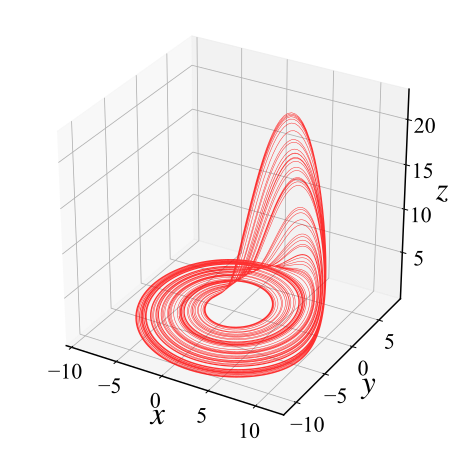

In [28]:
plt.rcParams['xtick.minor.visible']=False
plt.rcParams['ytick.minor.visible']=False

t0=80.; t0_=int(t0/dt)

# plot 3D trajectory
fig_RS3d, ax = plt.subplots(1,1,figsize=(8,8),subplot_kw={'projection':'3d'})
# t0<t<T
ax.plot(xyz[t0_:,0],xyz[t0_:,1],xyz[t0_:,2],'r',lw=0.5,alpha=0.8)

ax.set_xlabel('$x$', fontsize=32)
ax.set_ylabel('$y$', fontsize=32)
ax.set_zlabel('$z$', fontsize=32)
# plt.savefig('FIGS/12_RS_3D.pdf')
plt.show()

In [15]:
# set parameter values
s0, r0, b0 = 8, 28, 8/3
r_H = s0*(s0+b0+3)/(s0-b0-1)
c0 = np.sqrt(b0*(r0-1))
Cp0= [c0,c0,r0-1]; Cm0=[-c0,-c0,r0-1]
print('r_H = ',np.round(r_H,2),'<',r0)
print('C_+ = ',np.round(Cp0,2),';  C_- = ',np.round(Cm0,2))
# define duration (T) and time-step (dt) and initial conditions (xyz0)
T=50; dt=0.01
xyz0 = [15,5,-10]
xyz1 = [1,1,1.001]

r_H =  25.23 < 28
C_+ =  [ 8.49  8.49 27.  ] ;  C_- =  [-8.49 -8.49 27.  ]


In [16]:
# Integrate numerically the LE 
t, xyz = txyz_LE(s0,r0,b0,T,dt,xyz0)
t, xyz1= txyz_LE(s0,r0,b0,T,dt,xyz1)

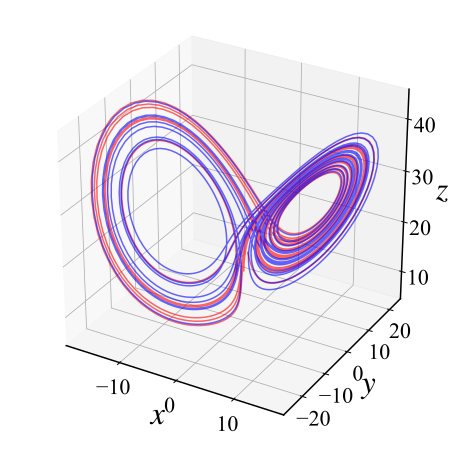

In [18]:
# Plot the 3D trajectory for t0<t<T
t0=25; t0_=int(t0/dt)
plt.rcParams['xtick.minor.visible']=False
plt.rcParams['ytick.minor.visible']=False

fig, ax = plt.subplots(1,1,figsize=(8,8),subplot_kw={'projection':'3d'})
ax.plot(xyz[t0_:,0],xyz[t0_:,1],xyz[t0_:,2],'r',alpha=0.6)
ax.plot(xyz1[t0_:,0],xyz1[t0_:,1],xyz1[t0_:,2],'b',alpha=0.6)
ax.set_xlabel('$x$', fontsize=32)
ax.set_ylabel('$y$', fontsize=32)
ax.set_zlabel('$z$', fontsize=32)
# plt.savefig('FIGS/Lorenz.pdf')
plt.show()

In [19]:
# set of points on the Lorenz attractor
data = xyz[t0_::20]
data.shape

(126, 3)

In [20]:
# generate a set of radii r
r_dat = [10**j for j in np.arange(-1.3,1.8,0.2)]

In [21]:
# calculate C(r)
%time rC = [[r,np.mean([np.sum([lg.norm(u-v)<r for u in data])-1 for v in data])] for r in r_dat] 


CPU times: user 2.3 s, sys: 45.6 ms, total: 2.35 s
Wall time: 2.73 s


In [22]:
k = 5*10**-3
rC = list(np.asarray(rC) + k)
print(rC)
# save C(r) data to file 
np.savez_compressed('data/rC_RS.npz',rC=rC)

#load C(r) data from file
dat = np.load('data/rC_RS.npz')
rC = dat[dat.files[0]]


[array([0.05511872, 0.005     ]), array([0.08443282, 0.005     ]), array([0.13089254, 0.005     ]), array([0.20452623, 0.005     ]), array([0.32122777, 0.1002381 ]), array([0.50618723, 0.3065873 ]), array([0.79932823, 0.52880952]), array([1.26392541, 0.94150794]), array([2.00026231, 1.78277778]), array([3.16727766, 4.56055556]), array([ 5.01687234, 10.46531746]), array([ 7.94828235, 21.37007937]), array([12.59425412, 42.24309524]), array([19.95762315, 78.62404762]), array([ 31.6277766 , 112.46531746]), array([ 50.12372336, 124.98912698])]


In [23]:
### Linear fit to (log(r)=LrCx,log(C(r))=LrCy)
rCx,rCy = np.asarray(rC[3:]).T
LrCx = np.log10(rCx); LrCy = np.log10(rCy)

def logd_fit(x,d_c,b_):
    return d_c*x+b_
n1=0; n2=-5
params = curve_fit(logd_fit,LrCx[n1:n2],LrCy[n1:n2])
d0_c,b0_ = params[0]
d_c = np.round(d0_c,2)
display(Latex('$d_c \simeq {}$ is fairly close to the accepted 2.013 value'.format(d_c)))

<IPython.core.display.Latex object>

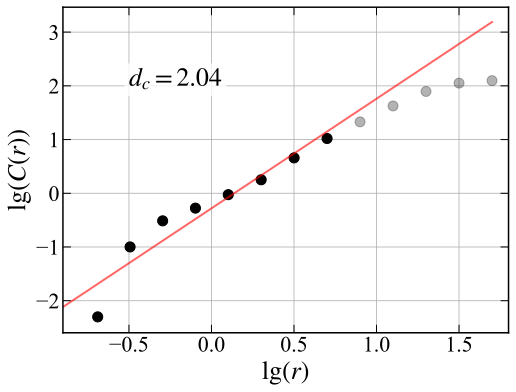

In [24]:
# plot C vs r
rr = np.linspace(-1.,1.7,80)

fig_RS_rC, ax = plt.subplots(figsize=(8,6))
ax.plot(LrCx,LrCy,'o',ms=10,mfc='k',mec='k',alpha=0.3)
ax.plot(LrCx[n1:n2],LrCy[n1:n2],'o',ms=10,mfc='k',mec='k')
ax.plot(rr,logd_fit(rr,d0_c,b0_),'r-',lw=2,alpha=0.6)

ax.set_xlim(-0.9,1.8)
ax.grid()
ax.text(-0.5,2,'$d_c = {}$'.format(d_c),fontsize=26,
       bbox=dict(edgecolor='w',facecolor='w',alpha=0.8))

ax.set_xlabel('$\lg(r)$')
ax.set_ylabel('$\lg(C(r))$')
# fig_RS_rC.savefig('FIGS/P12_RS_rC.pdf')
plt.show()                

In [99]:
display(Latex('$d_c \simeq {}$ is fairly close to the accepted 2.013 value'.format(2.05)))

<IPython.core.display.Latex object>